## ANLP Assignment 1: Sentiment Analysis
### Christopher Hamilton,  a1766121

In [1]:
import json
import os 

import pandas as pd
import numpy as np
from langdetect import detect as detect_language

### 1. Reading dataset and initial pre-processing

In [2]:
def read_json_to_df(file_name):
    data = []
    with open(file_name) as data_file:
        for line in data_file:
            data.append(json.loads(line))    

    return pd.json_normalize(data)

train_df = read_json_to_df("hotel_reviews_train.json")

In [3]:
train_df.head()

,title,text,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,ratings.service,ratings.cleanliness,...,ratings.rooms,author.username,author.num_reviews,author.id,author.location,author.num_cities,author.num_helpful_votes,author.num_type_reviews,ratings.check_in_front_desk,ratings.business_service_(e_g_internet_access)
0,“Horrible experience”,First of all we got there and they didn't have...,September 2012,80138,0,"September 19, 2012",140716137,False,1.0,2.0,...,1.0,Kh3RD,1.0,AB404BB664D653ECF79DE0E0867F6D34,"Las Vegas, Nevada",NaN,NaN,NaN,NaN,NaN
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,June 2011,240151,1,"June 27, 2011",114807323,False,1.0,1.0,...,NaN,TheUglyPhotographer,4.0,BB116F87FE8F9AB356F63853BFD32FFE,"Oceanside, California",3.0,4.0,4.0,NaN,NaN
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,October 2010,80793,0,"October 25, 2010",84805430,False,4.0,5.0,...,4.0,Moonstonemoclips,48.0,F3D0CF371B788300E73A1413B2DABB4B,Kirkland,31.0,27.0,32.0,NaN,NaN
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,June 2012,111418,1,"June 28, 2012",132971117,False,3.0,2.0,...,1.0,JoanellenJ,22.0,BC6BC07F81B768F78B6CE17A18762C11,New York,10.0,9.0,5.0,NaN,NaN
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...",January 2012,671150,3,"February 4, 2012",124104157,False,NaN,NaN,...,NaN,Lynnworks,3.0,F7E9D044FA2554FD06A871289312E043,Providence,3.0,7.0,3.0,NaN,NaN


In [4]:
predict_overall_train_df = train_df[["title", "text", "ratings.overall"]]

predict_overall_train_df.head()
predict_overall_train_df["ratings.overall"].value_counts()

ratings.overall
5.0    9825
4.0    7720
3.0    3287
2.0    1611
1.0    1557
Name: count, dtype: int64

In [5]:
predict_overall_train_df.loc[:,'title'] = ["".join(filter(lambda c: str.isalnum(c) or str.isspace(c), char)) for char in predict_overall_train_df.title]
predict_overall_train_df.loc[:,'text'] = ["".join(filter(lambda c: str.isalnum(c) or str.isspace(c), char)) for char in predict_overall_train_df.text]

In [6]:
predict_overall_train_df.head()

,title,text,ratings.overall
0,Horrible experience,First of all we got there and they didnt have ...,1.0
1,Stay Away,Found Racist graffiti in the room Request to c...,1.0
2,Great location and service,Close to Union Square hotel is a bit of a maz...,4.0
3,I will never go back here again,I had a bad vibe about this place from the mom...,2.0
4,Ripped off our VISA card after departure,After we received our final bill and left the ...,1.0


In [7]:
def filter_english_reviews(df):
    def is_english(text):
        try:
            return detect_language(text) == "en"
        except:
            return False

    return df[df['text'].apply(is_english) & df['title'].apply(is_english)]

In [8]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
# https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

# Save the English reviews to a CSV file to save time filtering when running again
if os.path.exists("english_hotel_reviews_train.csv"):
    predict_overall_train_df = pd.read_csv("english_hotel_reviews_train.csv")
else:
    predict_overall_train_df = filter_english_reviews(predict_overall_train_df)
    predict_overall_train_df.to_csv("english_hotel_reviews_train.csv", index=False)

In [9]:
predict_overall_train_df.head()

,title,text,ratings.overall
0,Great location and service,Close to Union Square hotel is a bit of a maz...,4.0
1,I will never go back here again,I had a bad vibe about this place from the mom...,2.0
2,Ripped off our VISA card after departure,After we received our final bill and left the ...,1.0
3,A great location,Steps to Grand Central a very well situated ho...,4.0
4,Its all about the Location,This Hotel is located right in the heart of Sa...,3.0


In [10]:
print(train_df.info())
print(predict_overall_train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 24 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   title                                           24000 non-null  object 
 1   text                                            24000 non-null  object 
 2   date_stayed                                     23050 non-null  object 
 3   offering_id                                     24000 non-null  int64  
 4   num_helpful_votes                               24000 non-null  int64  
 5   date                                            24000 non-null  object 
 6   id                                              24000 non-null  int64  
 7   via_mobile                                      24000 non-null  bool   
 8   ratings.service                                 21550 non-null  float64
 9   ratings.cleanliness                    

### 2. Exploratory Data Analysis (EDA)

In [11]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /home/dev/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

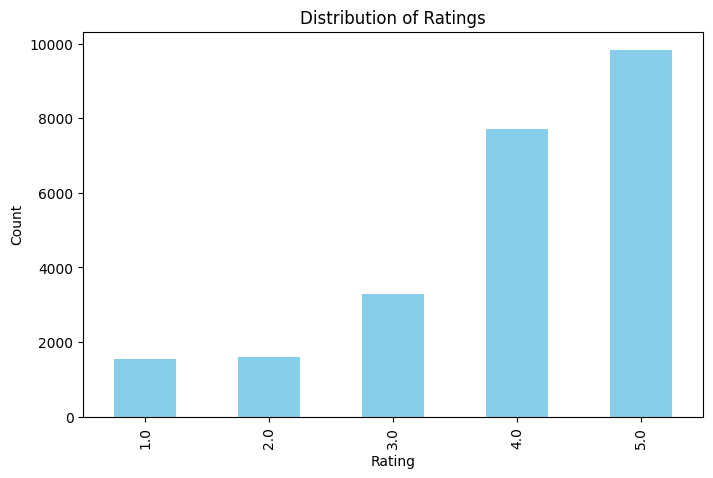

In [12]:
import matplotlib.pyplot as plt

# Plot distribution of ratings
train_df['ratings.overall'].value_counts().sort_index().plot(kind='bar', figsize=(8,5), color='skyblue')

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)  # Remove common words
X = vectorizer.fit_transform(train_df["text"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

correlations = tfidf_df.corrwith(train_df["ratings.overall"])
correlations = correlations.sort_values(ascending=False)  # Sort by importance

# Find words with the weakest correlation (near zero)
non_predictive_words = correlations.sort_values(key=lambda x: np.abs(x))
print("Non-Predictive Words:\n", non_predictive_words.head(10))

# Display top positive and negative correlated words
print("Most Positive Words:\n", correlations.head(10))
print("\nMost Negative Words:\n", correlations.tail(10))

Non-Predictive Words:
 jane         0.000003
familiar     0.000005
teenagers    0.000028
39          -0.000029
extend      -0.000033
couches      0.000035
doughnuts   -0.000042
bldg        -0.000043
queue        0.000045
keeping      0.000047
dtype: float64
Most Positive Words:
 great          0.251586
staff          0.196470
friendly       0.167828
comfortable    0.159558
helpful        0.156769
wonderful      0.153227
excellent      0.148437
perfect        0.147401
highly         0.132126
loved          0.126517
dtype: float64

Most Negative Words:
 carpet     -0.153744
bad        -0.155436
room       -0.156964
horrible   -0.164654
terrible   -0.168106
rude       -0.182339
said       -0.185605
worst      -0.212137
dirty      -0.233399
told       -0.250588
dtype: float64


In [14]:
# Split all reviews into words and find unique ones
all_words_text = predict_overall_train_df.text.apply(nltk.word_tokenize)
all_words_title = predict_overall_train_df.title.apply(nltk.word_tokenize)

all_words = pd.concat([all_words_text, all_words_title])
unique_words = np.unique(all_words)

print("Total Unique Words:", len(unique_words))


Total Unique Words: 35245


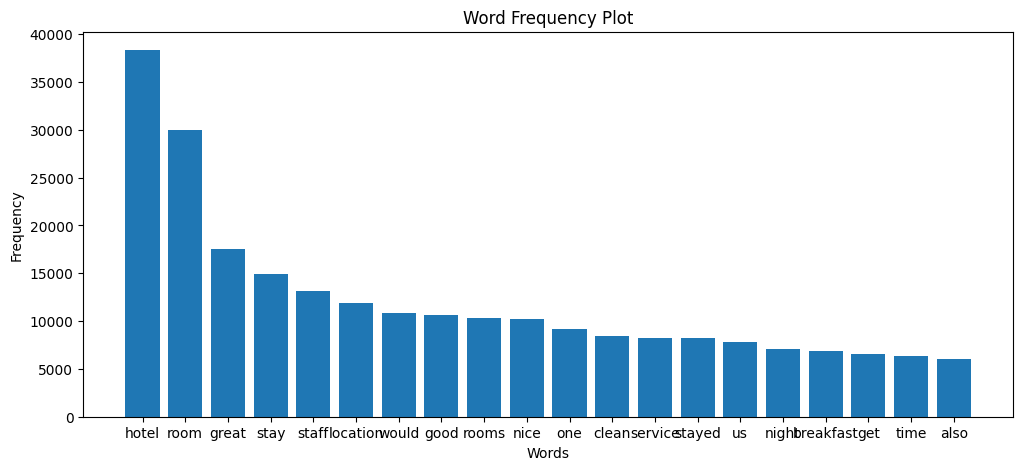

In [15]:
# Word frequency plots are used to visualize the most common words in a dataset.

from collections import Counter
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

tokens = [
    word.lower() for sentence in unique_words.tolist()
    for s in sentence
    for word in word_tokenize(s)
    if word.isalnum() and word.lower() not in stop_words
]

word_freq = Counter(tokens)

plt.figure(figsize=(12, 5))
plt.bar(*zip(*word_freq.most_common(20)))
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Plot")
plt.show()


Distribution of 3-grams:
within walking distance: 777
front desk staff: 690
hotel great location: 587
staff friendly helpful: 576
would definitely stay: 544
would recommend hotel: 311
great place stay: 304
empire state building: 289
flat screen tv: 285
stayed one night: 264
would highly recommend: 258
highly recommend hotel: 252
new york city: 246
great location great: 231
called front desk: 212
right across street: 204
recommend hotel anyone: 190
hotel good location: 179
would definitely recommend: 177
easy walking distance: 159
great hotel great: 152
stayed 3 nights: 152
hotel staff friendly: 140
king size bed: 137
stayed two nights: 132
walk times square: 129
staff great location: 129
right next door: 127
location great hotel: 126
room clean comfortable: 125
stayed 4 nights: 122
front desk clerk: 121
really enjoyed stay: 119
friendly helpful staff: 118
stayed 2 nights: 117
made us feel: 115
staff helpful friendly: 112
clean staff friendly: 109
good value money: 109
two double beds: 

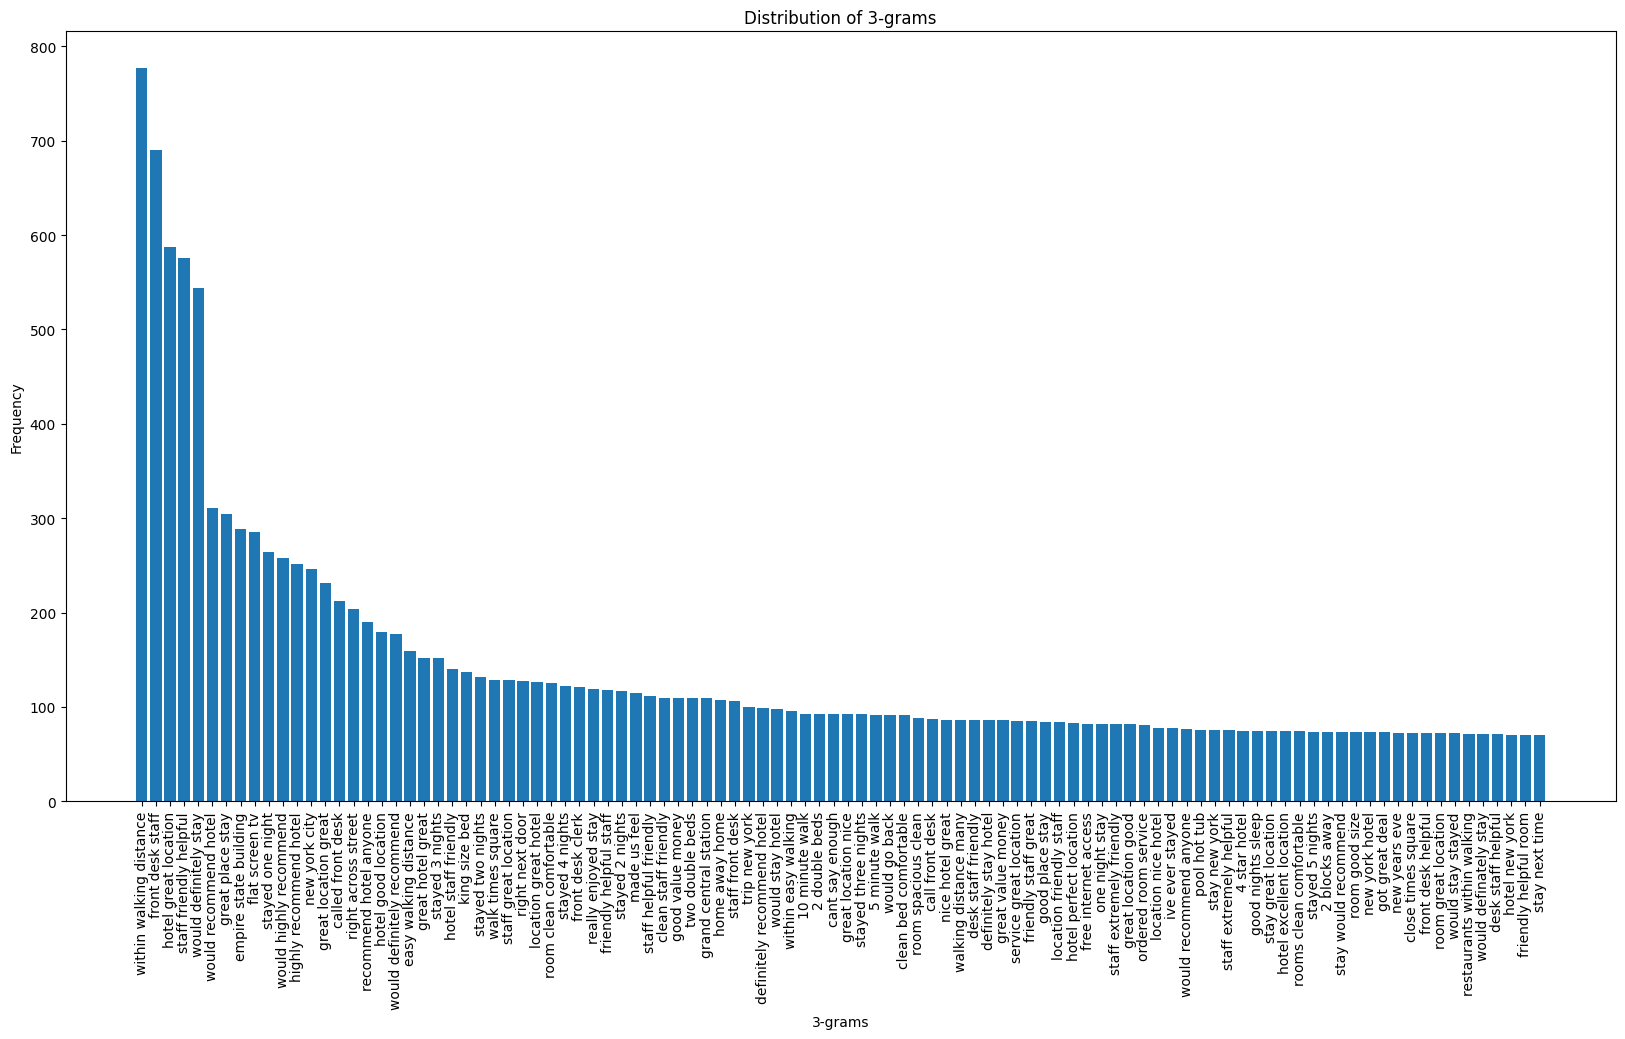

In [17]:
# Identifying common N-grams: N-grams are sequences of words. 
# Identifying common n-grams can give insight into the most common phrases in the dataset.

from nltk import ngrams
from collections import Counter
import matplotlib.pyplot as plt

# Function to generate n-grams
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

# Specify the value of n for n-grams
n_value = 3  # You can change this value to see different n-grams, e.g., 2 for bigrams, 3 for trigrams, etc.

# Generate n-grams
ngrams_list = generate_ngrams(tokens, n_value)

# Count the occurrences of each n-gram
ngrams_count = Counter(ngrams_list)
most_common_ngrams = ngrams_count.most_common(100)

# Display the distribution
print(f"Distribution of {n_value}-grams:")
for ngram, count in most_common_ngrams:
    print(f"{ngram}: {count}")

# Plot the distribution
labels, values = zip(*most_common_ngrams)
indexes = range(len(labels))

plt.figure(figsize=(20, 10))
plt.bar(indexes, values)
plt.xlabel(f'{n_value}-grams')
plt.ylabel('Frequency')
plt.xticks(indexes, labels, rotation='vertical')
plt.title(f'Distribution of {n_value}-grams')
plt.show()

### 3. Selection and training Machine Learning models

In [18]:
from sklearn.model_selection import train_test_split

X_res = pd.concat([predict_overall_train_df["title"], predict_overall_train_df["text"]], axis=1)
X_res = X_res["title"] + " " + X_res["text"]
y_res = predict_overall_train_df["ratings.overall"]

X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, shuffle=True)


In [19]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_val_vectors = vectorizer.transform(X_val)

In [20]:
result_dict_train = {}
result_dict_test = {}


In [21]:
from sklearn.model_selection import cross_val_score


#### Multinomial Naive Bayes

In [22]:
from sklearn.naive_bayes import MultinomialNB

# https://www.geeksforgeeks.org/multinomial-naive-bayes/

classifier = MultinomialNB()

In [23]:
nb_accuracies = cross_val_score(classifier, X_train_vectors, y_train, cv=5)
classifier.fit(X_train_vectors, y_train)
print("Naive Bayes Train Score:", np.mean(nb_accuracies))
result_dict_train["Naive Bayes Default Train Score"] = np.mean(nb_accuracies)

Naive Bayes Train Score: 0.5790727876404357


In [25]:
naive_bayes_score = classifier.score(X_val_vectors, y_val)
print("Naive Bayes Test Score:", naive_bayes_score)
result_dict_test["Naive Bayes Default Validation Score"] = naive_bayes_score


Naive Bayes Test Score: 0.5949735449735449


In [26]:
import tensorflow as tf

# Limit GPU memory usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=(6 * 1024))])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2025-03-29 12:15:48.484154: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-29 12:15:48.493053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743212748.502109   59275 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743212748.504715   59275 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743212748.512165   59275 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1743212749.674797   59275 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6144 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6


In [27]:
from tensorflow.keras.utils import to_categorical

train_Y = train_df["ratings.overall"]
val_Y = ["ratings.overall"]
train_Y_cat = to_categorical(train_df["ratings.overall"]-1, num_classes=5)

In [ ]:
import requests
import zipfile

#https://towardsdatascience.com/1-to-5-star-ratings-classification-or-regression-b0462708a4df/
#https://www.kaggle.com/code/sebastianpoliak/classification-or-regression

glove_dir = '../glove'
if not os.path.exists(glove_dir):
    os.makedirs(glove_dir)

glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = os.path.join(glove_dir, "glove.6B.zip")

# Download the GloVe file
if not os.path.exists(glove_zip_path):
    print("Downloading GloVe embeddings...")
    response = requests.get(glove_url, stream=True)
    with open(glove_zip_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Download complete.")

# Extract the GloVe file
if not os.path.exists(os.path.join(glove_dir, "glove.6B.100d.txt")):
    print("Extracting GloVe embeddings...")
    with zipfile.ZipFile(glove_zip_path, "r") as zip_ref:
        zip_ref.extractall(glove_dir)
    print("Extraction complete.")

embedding_index = {}
f = open(os.path.join(glove_dir,'glove.6B.100d.txt'),encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embedding_index[word] = coefs
f.close()
print('Found %s word vectors ' % len(embedding_index))

Found 400000 word vectors 


In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer=Tokenizer(oov_token="'oov'")
tokenizer.fit_on_texts(train_df['text'])

max_words = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((max_words,embedding_dim))

for word, idx in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [31]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 200
train_X = pad_sequences(tokenizer.texts_to_sequences(train_df['text']), maxlen=maxlen)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

#https://towardsdatascience.com/1-to-5-star-ratings-classification-or-regression-b0462708a4df/
#https://www.kaggle.com/code/sebastianpoliak/classification-or-regression

model=Sequential()
model.add(Embedding(max_words, embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(16, activation="relu"))
model.add(Dense(5, activation="softmax"))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

# Train the model
history = model.fit(
    train_X,
    train_Y_cat,
    epochs=25,
    batch_size=256,
    validation_split=0.2,
)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │     4,112,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,112,300 (15.69 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,112,300 (15.69 MB)

None
Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3294 - loss: 1.5132 - val_accuracy: 0.4206 - val_loss: 1.3335
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4509 - loss: 1.2866 - val_accuracy: 0.4606 - val_loss: 1.2529
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4745 - loss: 1.2086 - val_accuracy: 0.4781 - val_loss: 1.1606
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4986 - loss: 1.1092 - val_accuracy: 0.5058 - val_loss: 1.0813
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5317 - loss: 1.0530 - val_accuracy: 0.5352 - val_loss: 1.0272
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5539 - loss: 1.0086 - val_accuracy: 0.5404 - val_loss: 1.0034
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5575 - loss: 0.9909 - val_accuracy: 0.5483 - val_loss: 0.9940
Epoch 8/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5736 - loss: 0.9613 - val_accuracy: 0.555

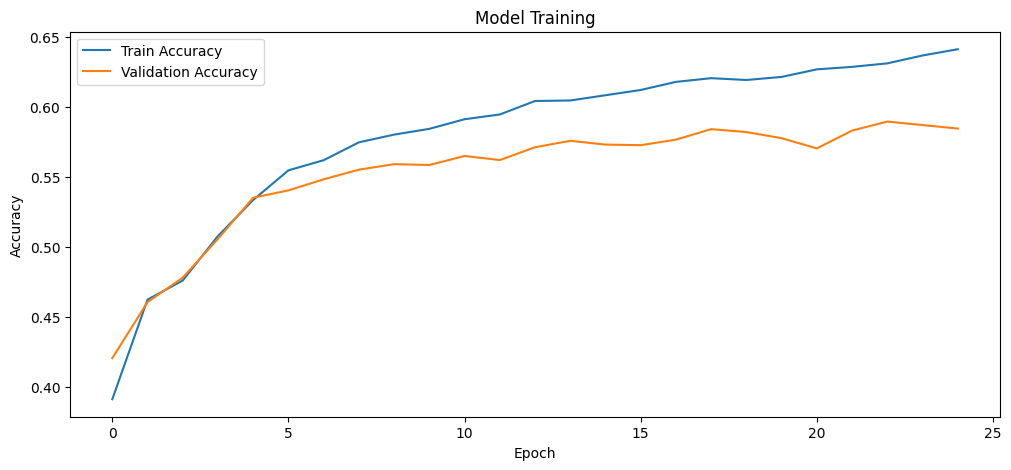

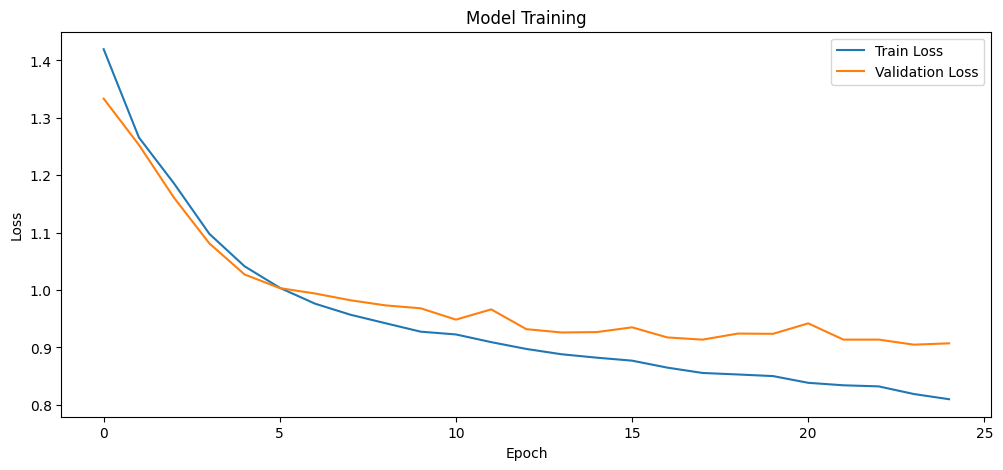

In [40]:
from matplotlib import pyplot as plt

# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Training')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training')
plt.legend()
plt.show()

### 4. Experiment with VADER sentiment lexicon

### 5. Final testing on test set and discussion of results

### 6. Propose a method to predict aspects 

***(COMP SCI 7417 and COMP SCI 7717 only)***

### 7. Reflection on the ***Product*** development.

### 9. References

https://pandas.pydata.org/pandas-docs/version/1.2.0/reference/api/pandas.json_normalize.html

https://www.analyticsvidhya.com/blog/2022/07/step-by-step-exploratory-data-analysis-eda-using-python/

https://pawarbi.github.io/blog/pandas/numpy/data-cleaning/2021/03/05/removing-non-alphanumeric-symbols-characters-from-column-numpy-pandas-dataframe.html


### Appendix